In [32]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, roc_curve, auc
import kerastuner as kt
from kerastuner.tuners import RandomSearch
import warnings
warnings.filterwarnings("ignore")

# Veri setini yükle
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000) # num_words=10000: En sık geçen ilk 10.000 kelime dahil edilir.





In [33]:
#veri ön işleme: yorumları aynı uzunluğa getirmek için padding yöntemi kullan
maxlen=100 #Tüm yorumlar 100 kelimeye uzatılır/ kısaltılır
x_train=pad_sequences(x_train,maxlen=maxlen) #train verisi uzunluğunu ayarla
x_test=pad_sequences(x_test,maxlen=maxlen)  #test verisi uzunluğu ayarla


In [34]:
from kerastuner.tuners import RandomSearch

# build_model fonksiyonu
def build_model(hp):
    max_len = 500  # Sabit uzunluk (padding için kullandık)
    
    model = Sequential()
    
    # Embedding katmanı: kelimeleri anlamlı vektörlere çevir
    model.add(Embedding(input_dim=10000,
                        output_dim=hp.Int("embedding_output", min_value=32, max_value=128, step=32),
                        input_length=max_len))
    
    # SimpleRNN katmanı : Sıralı verileri (cümleleri) anlamak.RNN, önceki kelimeleri hatırlayarak karar verir.
    model.add(SimpleRNN(units=hp.Int("rnn_units", min_value=128, max_value=256, step=32)))
    
    # Dropout: overfitting’i(ezberlemeyi) azaltır. 
    model.add(Dropout(rate=hp.Float("dropout_rate", min_value=0.2, max_value=0.5, step=0.1)))
    
    # Çıkış katmanı
    model.add(Dense(1, activation="sigmoid"))
    
    # Derleme
    model.compile(
        optimizer=hp.Choice("optimizer", ["adam", "rmsprop"]),
        loss="binary_crossentropy",
        metrics=["accuracy", "AUC"]
    )
    
    return model

# Tuner ayarları (RandomSearch)
tuner = RandomSearch(
    build_model,
    objective="val_loss",
    max_trials=2,  # Hızlı denemek için az tuttuk, istersen artırabilirsin
    executions_per_trial=1,
    directory="rnn_tuner_directory",
    project_name="imdb_rnn"
)


Reloading Tuner from rnn_tuner_directory\imdb_rnn\tuner0.json


In [35]:
early_stopping=EarlyStopping(monitor="val_loss",patience=3,restore_best_weights=True)

In [36]:
#modelin eğitimi
tuner.search(x_train,y_train,
             epochs=5,
             validation_split=0.2,
             callbacks=[early_stopping])

782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - AUC: 0.8049 - accuracy: 0.7304 - loss: 0.5481
Test Loss: 0.543, test accuracy: 0.734, test auc: 0.810
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step
              precision    recall  f1-score   support

           0       0.69      0.85      0.76     12500
           1       0.81      0.62      0.70     12500

    accuracy                           0.73     25000
   macro avg       0.75      0.73      0.73     25000
weighted avg       0.75      0.73      0.73     25000



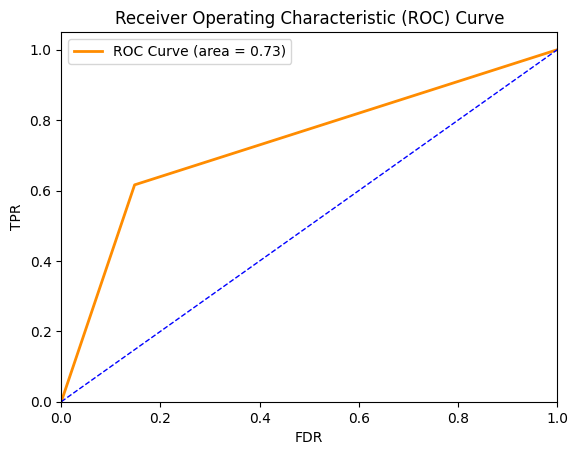

In [37]:
from sklearn.metrics import classification_report, roc_curve, auc  # garanti olsun

best_model = tuner.get_best_models(num_models=1)[0]
loss, accuracy, auc_score = best_model.evaluate(x_test, y_test)
print(f"Test Loss: {loss:.3f}, test accuracy: {accuracy:.3f}, test auc: {auc_score:.3f}")

# Tahmin yap
y_pred_prob = best_model.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype("int32")

# Sınıflandırma raporu
print(classification_report(y_test, y_pred))

# ROC hesapla
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# ROC grafiği çiz
plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC Curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="blue", lw=1, linestyle="--")
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel("FDR")
plt.ylabel("TPR")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()


                            